### Example: Phase separation
We setup a system of randomly dispersed `"A"` and `"B"` type particles, in equal proportions, run a short simulation, and examine the resulting trajectory.

In [10]:
import h5py
import numpy as np


def setup_system(box_size, number_density, out_path):
    """Setup a simple system of independent particles with no bonds
    
    Parameters
    ----------
    box_size : list of float
        Simulation box size in nm.
    number_density : float
        Number density per nm squared of particles in the simulation box.
    out_path : str
        Path of the created structure file.
    """
    box_size = np.asarray(box_size, dtype=np.float32)
    volume = np.prod(box_size)
    n_particles = int(number_density * volume)
    n_particles -= np.mod(n_particles, 2)
    
    with h5py.File(out_path, "w") as out_file:
        position_dataset = out_file.create_dataset(
            "coordinates",
            (1, n_particles, box_size.size,),
            dtype="float32",
        )
        types_dataset = out_file.create_dataset(
            "types",
            (n_particles,),
            dtype="i",
        )
        names_dataset = out_file.create_dataset(
            "names",
            (n_particles,),
            dtype="S10",
        )
        indices_dataset = out_file.create_dataset(
            "indices",
            (n_particles,),
            dtype="i",
        )
        
        types_dataset[:n_particles//2] = 0
        types_dataset[n_particles//2:] = 1
        names_dataset[:n_particles//2] = np.string_("A")
        names_dataset[n_particles//2:] = np.string_("B")
        indices_dataset[...] = np.arange(n_particles)
        position_dataset[...] = np.random.uniform(
            low=0.0, high=box_size, size=(1, n_particles, box_size.size),
        )

# 1042 particles in a 5nm x 5nm x 5nm simulation box.
setup_system([10, 10, 10], 8.333, "phase_separation_10x10x10nm.HDF5")

### Run the simulation
We run one simulation with &chi; less than the critical point of phase separation, and one for &chi; well over: 
```bash
# chi=5.0
mpirun -n 6 python3 /Users/mortenledum/Documents/HyMD/hymd/__main__.py \
                    phase_separation.toml      \
                    phase_separation.HDF5      \
                    --seed 1                   \
                    --verbose 1
mv sim.H5 sim_chi=5.H5

# chi=40.0
gsed -i "17s/^.*$/  ['A', 'B', 40.0],/" phase_separation.toml
mpirun -n 6 python3 /Users/mortenledum/Documents/HyMD/hymd/__main__.py \
                    phase_separation.toml      \
                    phase_separation.HDF5      \
                    --seed 1                   \
                    --verbose 1
mv sim.H5 sim_chi=40.H5
```

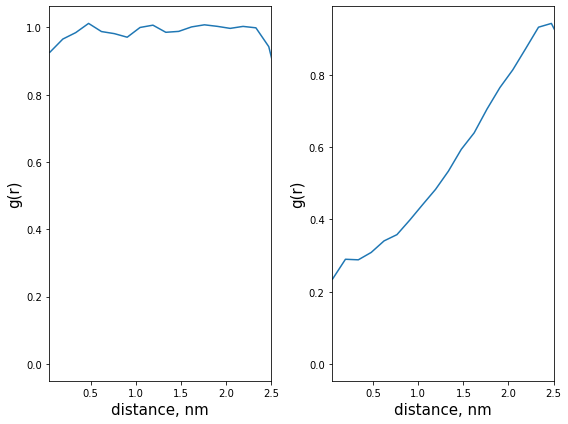

In [94]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array


def compute_radial_distribution_function(simulation_file, 
                                         selection_1, 
                                         selection_2, 
                                         frames=None, 
                                         bins=30):
    """Compute the radial distribution function between selections of particles
    
    Borrows some fast distance calculation C code from MDAnalysis through 
    `MDAnalysis.lib.distances.distance_array`. 
    
    Parameters
    ----------
    simulation_file : str
        File path of .H5MD simulation file.
    selection_1 : str
        Name of first selection type.
    selection_2 : str
        Name of second selection type.
    frames : list, optional
        List of frame numbers to calculate the RDF for.
    bins : int, optional
        Number of bins to use in the histogram binning of RDF data.
    
    Returns
    -------
    edges : numpy.ndarray
        Edges of the bins used to bin the RDF data.
    histogram : numpy.ndarray
        RDF values at the distances of the corresponding `edges`. 
    """
    with h5py.File(simulation_file, "r") as in_file:
        box_size = in_file["/particles/all/box/edges"][...]
        positions = in_file["/particles/all/position/value"][...]
        types = in_file["/particles/all/species"][...]
        indexOfSpecies = in_file["/parameters/vmd_structure/indexOfSpecies"][...]
        names = in_file["/parameters/vmd_structure/name"][...]
    
    volume = np.prod(box_size)
    max_distance = np.sqrt(np.sum((0.5 * box_size)**2))
    box = np.array([box_size[0], box_size[1], box_size[2], 90.0, 90.0, 90.0])
    
    index_1 = np.where(names == np.string_(selection_1))
    index_2 = np.where(names == np.string_(selection_2))
    
    ind_1 = np.where(types == index_1[0])
    ind_2 = np.where(types == index_2[0])
    n_selection_1 = len(ind_1[0])
    n_selection_2 = len(ind_2[0])
        
    if frames is None:
        iter_range = list(range(positions.shape[0]))
    else:
        iter_range = frames
    n_frames = len(iter_range)
    
    distances = np.zeros(shape=(n_selection_1, n_selection_2), dtype=np.float64)
    histogram = np.zeros(shape=(bins,), dtype=np.float64)

    for i in iter_range:
        distance_array(
            np.squeeze(positions[i, ind_1, :]), 
            np.squeeze(positions[i, ind_2, :]), 
            box=box, 
            result=distances,
        )
        count, edges = np.histogram(
            distances, bins=bins, range=(0.05, max_distance)
        )
        histogram += count
    
    sphere_volumes = np.power(edges, 3)
    fractional_volumes = 4/3 * np.pi * np.diff(sphere_volumes)
    density = n_selection_1 * n_selection_2 / volume
    return edges, histogram / (density * fractional_volumes * n_frames)
    

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(8)
fig.set_figheight(6)
font_opts = {"fontsize": 15}

file_path_1 = "sim_chi=5.H5"
file_path_2 = "sim_chi=40.H5"
for ax, file_path in zip((axs[0], axs[1]), (file_path_1, file_path_2)):
    edges, rdf = compute_radial_distribution_function(
        file_path, "A", "B", range(2, 5), bins=30,
    )
    ax.plot(edges[:-1], rdf)
    ax.set_xlim((0.04, 2.5))
    ax.set_xlabel("distance, nm", **font_opts)
    ax.set_ylabel("g(r)", **font_opts)
fig.tight_layout()
plt.show()
